In [3]:
import pandas as pd
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

# Load the uploaded fantasy football league data
file_name = 'Fantasy Football Data - Sheet1.csv'
ff_data = pd.read_csv(file_name)

# Displaying the first few rows of the data to understand its structure
ff_data.head()

,week,team_1,team_1_score,team_2,team_2_score
0,1,SF Snicker Optimizers,98.44,Gofers,67.42
1,1,Gonna Achilles Myself,124.94,Louisiana Chantin' Chodes,68.16
2,1,Wills Sink Puke,96.26,Gum Pillows,108.14
3,1,Ron Don Volante,79.32,Show time,74.58
4,1,Obj and the Gang,113.08,Nathan Peterman was railroaded,95.26


In [19]:
def calculate_elo(winner_elo, loser_elo, margin):
    """
    Calculate the new Elo ratings for the winner and loser of a match.
    """
    K = 30  # Elo K-factor
    margin_multiplier = np.log(max(margin, 1)) * (2.2 / ((winner_elo - loser_elo) * 0.001 + 2.2))

    expected_win = 1 / (1 + 10 ** ((loser_elo - winner_elo) / 400))
    change_in_elo = K * margin_multiplier * (1 - expected_win)

    return round(winner_elo + change_in_elo), round(loser_elo - change_in_elo)

# Initialize Elo scores
elo_scores = defaultdict(lambda: 1500)  # Default Elo score for a new team

# DataFrame to store weekly Elo scores for each team
elo_history = pd.DataFrame(columns=['Week'] + list(set(ff_data['team_1']).union(set(ff_data['team_2']))))

# Iterating over each week and match to update Elo scores
for week in ff_data['week'].unique():
    week_data = ff_data[ff_data['week'] == week]
    week_elo_scores = {'Week': week}

    for _, row in week_data.iterrows():
        team1, team1_score = row['team_1'], row['team_1_score']
        team2, team2_score = row['team_2'], row['team_2_score']

        if team1_score > team2_score:
            elo_scores[team1], elo_scores[team2] = calculate_elo(elo_scores[team1], elo_scores[team2], team1_score - team2_score)
        else:
            elo_scores[team2], elo_scores[team1] = calculate_elo(elo_scores[team2], elo_scores[team1], team2_score - team1_score)
        
        week_elo_scores[team1] = elo_scores[team1]
        week_elo_scores[team2] = elo_scores[team2]

        week_elo_scores_df = pd.DataFrame(week_elo_scores, index=[week])

    elo_history = pd.concat([elo_history, week_elo_scores_df])

# Setting the index to 'Week' for plotting
elo_history.set_index('Week', inplace=True)

# Displaying the updated Elo scores dataframe
elo_history.head()


,Show time,Juan and done,An Actual Playoff Contender,Ron Don Volante,Louisiana Chantin' Chodes,Wills Sink Puke,Nathan Peterman was railroaded,Gonna Achilles Myself,Gum Pillows,Obj and the Gang,The Football Team,SF Snicker Optimizers,Gofers,Los SexTape
Week,,,,,,,,,,,,,,
1,1477,1481,1444,1523,1439,1463,1457,1561,1537,1543,1556,1552,1448,1519
2,1507,1451,1452,1472,1395,1550,1449,1474,1588,1497,1607,1598,1492,1468
3,1553,1420,1452,1421,1361,1601,1410,1426,1619,1531,1561,1598,1540,1507
4,1583,1402,1368,1372,1445,1619,1380,1475,1666,1584,1514,1647,1487,1458
5,1646,1458,1333,1316,1391,1637,1440,1522,1606,1537,1496,1584,1522,1512


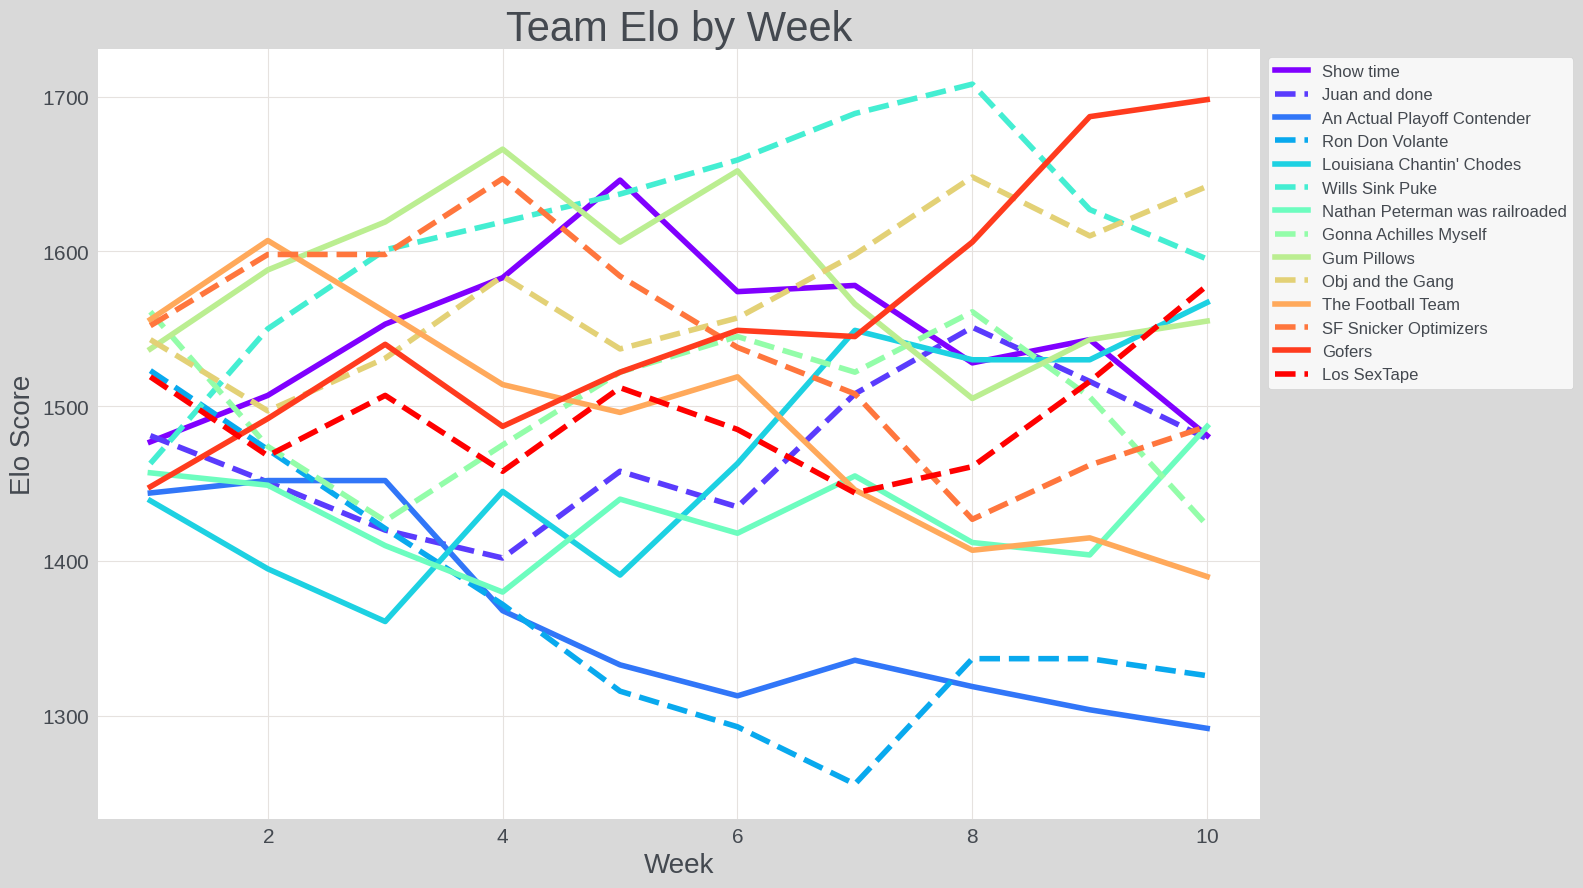

In [20]:
# Modifying the plot with alternating solid and dashed lines for better distinction
plt.figure(figsize=(15, 10))

# Using a rainbow colormap
colors = plt.cm.rainbow(np.linspace(0, 1, len(elo_history.columns)))

for idx, (team, color) in enumerate(zip(elo_history.columns, colors)):
    linestyle = '-' if idx % 2 == 0 else '--'  # Solid line for even index, dashed for odd
    plt.plot(elo_history.index, elo_history[team], label=team, color=color, linestyle=linestyle)

plt.title('Team Elo by Week')
plt.xlabel('Week', fontsize=20)
plt.ylabel('Elo Score', fontsize=20)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)

plt.show()